Merged Data Date Range:
2020-01-01 00:00:00 2022-12-01 00:00:00
            Change_Rate
Date                   
2020-01-01     1.000000
2020-02-01    -0.082319
2020-03-01    -0.123514
2020-04-01     0.128194
2020-05-01     0.047627
2020-06-01     0.019888
2020-07-01     0.056385
2020-08-01     0.071880
2020-09-01    -0.037997
2020-10-01    -0.026593
2020-11-01     0.109464
2020-12-01     0.038449
2021-01-01    -0.010096
2021-02-01     0.027574
2021-03-01     0.043796
2021-04-01     0.053369
2021-05-01     0.006984
2021-06-01     0.023345
2021-07-01     0.023754
2021-08-01     0.030406
2021-09-01    -0.046509
2021-10-01     0.070061
2021-11-01    -0.006929
2021-12-01     0.044816
2022-01-01    -0.051747
2022-02-01    -0.029942
2022-03-01     0.037130
2022-04-01    -0.087202
2022-05-01     0.001834
2022-06-01    -0.082544
2022-07-01     0.092204
2022-08-01    -0.040781
2022-09-01    -0.092100
2022-10-01     0.080961
2022-11-01     0.055885
2022-12-01    -0.057615
Train on 24 samples, val

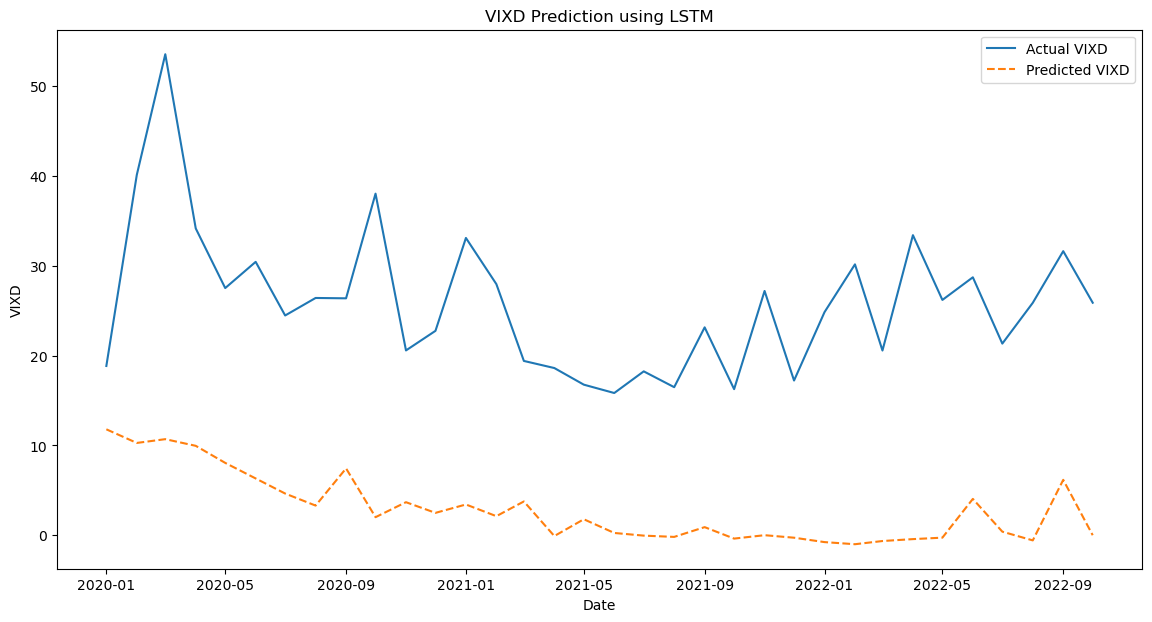

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 加载情绪结果文件
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')

# 加载市场指数数据
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/modified_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/modified_SPXTRD2.xlsx')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/modified_VIXD.xlsx', sheet_name='Price Data')

# 确保日期列为datetime类型
finbert_data['Date'] = pd.to_datetime(finbert_data['Date'])
textblob_data['Date'] = pd.to_datetime(textblob_data['Date'])
vader_data['Date'] = pd.to_datetime(vader_data['Date'])
spxd_data['Date'] = pd.to_datetime(spxd_data['Date'])
spxtrd_data['Date'] = pd.to_datetime(spxtrd_data['Date'])
vixd_data['Date'] = pd.to_datetime(vixd_data['Date'])

# 删除2023年的数据
finbert_data = finbert_data[finbert_data['Date'].dt.year != 2023]
textblob_data = textblob_data[textblob_data['Date'].dt.year != 2023]
vader_data = vader_data[vader_data['Date'].dt.year != 2023]
spxd_data = spxd_data[spxd_data['Date'].dt.year != 2023]
spxtrd_data = spxtrd_data[spxtrd_data['Date'].dt.year != 2023]
vixd_data = vixd_data[vixd_data['Date'].dt.year != 2023]

# 合并情绪得分数据
sentiment_data = pd.merge(finbert_data, textblob_data, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data, on='Date', how='outer')

# 合并市场指数数据
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# 合并所有数据
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# 检查合并后的日期范围
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())
print(data[['Change_Rate']])

X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'SPXD_Mean', 'SPXTRD_Mean','Change_Rate']]
y = data['VIXD_Mean'].shift(-1)

# 删除目标变量中的NaN值，并对齐特征变量的索引
y = y.dropna()
X = X.loc[y.index]

# 删除与目标变量对齐后的最后一行
X = X.iloc[:-1, :]
y = y.iloc[:-1]

# 调整特征权重
weights = {
    'Overall Positive Sentiment': 0.5,
    'Overall Neutral Sentiment': 0.1,
    'Overall Negative Sentiment': 0.5,
    'Polarity': 0.5,
    'Subjectivity': 0.1,
    'Positive': 0.3,
    'Neutral': 0.1,
    'Negative': 0.3,
    'SPXD_Mean': 0.7,
    'SPXTRD_Mean': 0.7,
    'Change_Rate':1
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# 确保特征和目标变量的索引对齐
X = X.loc[y.index]
data = data.loc[y.index]  # 同步删除 data 中的对应行

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 拆分训练集和测试集
split_date = '2022-01-01'
split_date = pd.to_datetime(split_date)
X_train = X_scaled[data.index < split_date]
X_test = X_scaled[data.index >= split_date]
y_train = y[data.index < split_date]
y_test = y[data.index >= split_date]

# 重塑数据以适应LSTM输入 [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=2, shuffle=False)

# 评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# 可视化预测结果
predicted_vixd = model.predict(X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])))
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['VIXD_Mean'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using LSTM')
plt.legend()
plt.show()


Train on 24 samples, validate on 10 samples
Epoch 1/200
24/24 - 6s - loss: 745.3322 - val_loss: 717.0937
Epoch 2/200
24/24 - 0s - loss: 744.7870 - val_loss: 716.6700
Epoch 3/200
24/24 - 0s - loss: 744.2681 - val_loss: 716.2333
Epoch 4/200
24/24 - 0s - loss: 743.6096 - val_loss: 715.7806
Epoch 5/200
24/24 - 0s - loss: 743.0595 - val_loss: 715.3092
Epoch 6/200
24/24 - 0s - loss: 742.4831 - val_loss: 714.8156
Epoch 7/200
24/24 - 0s - loss: 741.8520 - val_loss: 714.2969
Epoch 8/200
24/24 - 0s - loss: 741.0932 - val_loss: 713.7542
Epoch 9/200
24/24 - 0s - loss: 740.1694 - val_loss: 713.1820
Epoch 10/200
24/24 - 0s - loss: 739.1443 - val_loss: 712.5763
Epoch 11/200
24/24 - 0s - loss: 738.0790 - val_loss: 711.9341
Epoch 12/200
24/24 - 0s - loss: 736.9564 - val_loss: 711.2544
Epoch 13/200
24/24 - 0s - loss: 735.4939 - val_loss: 710.5363
Epoch 14/200
24/24 - 0s - loss: 733.8831 - val_loss: 709.7753
Epoch 15/200
24/24 - 0s - loss: 732.0832 - val_loss: 708.9686
Epoch 16/200
24/24 - 0s - loss: 729

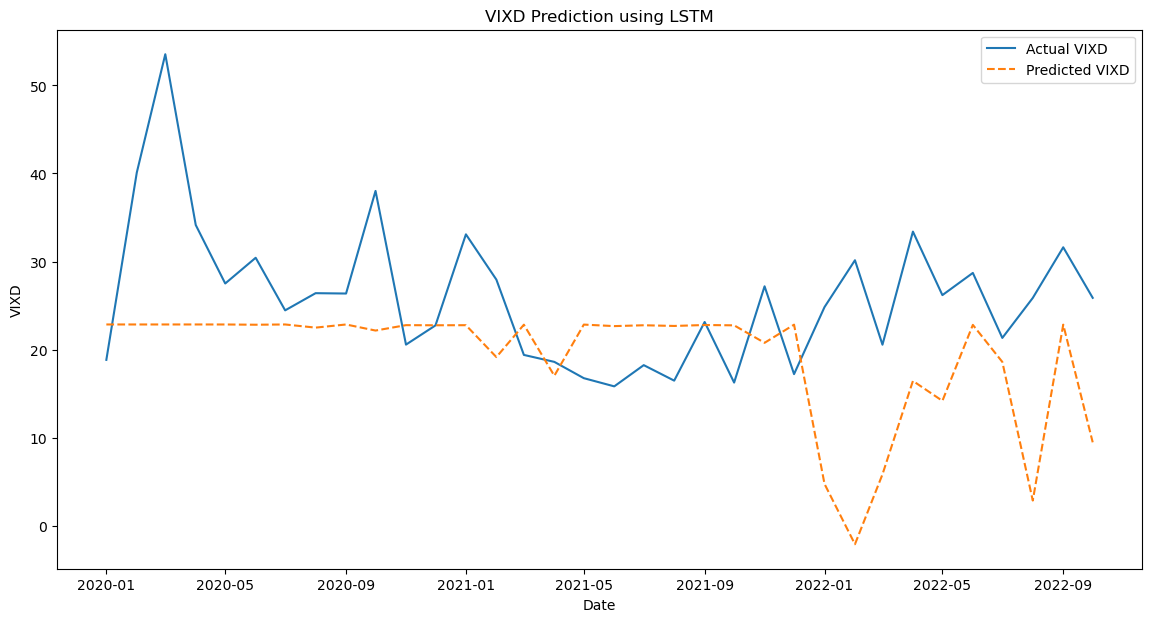

In [5]:
# 构建更复杂的LSTM模型
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# 提前停止
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 训练模型，增加epochs数
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=2, shuffle=False)

# 评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# 可视化预测结果
predicted_vixd = model.predict(X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1])))
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['VIXD_Mean'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using LSTM')
plt.legend()
plt.show()
